In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import sys

sys.path.append("../")

from vae_interp.dataset import load_nouns_dataset
import matplotlib.pyplot as plt
from vae_interp.sae import SAE
from vae_interp.vae import VAE
import torch

In [3]:
dataset = load_nouns_dataset(image_size=64, normalize=True)

In [10]:
vae = VAE.load_from_dir("../weights/vae")
sae = SAE.load_from_checkpoint("../weights/sae/sae_config.json", "../weights/sae/sae.pth")

vae.eval()
sae.eval()

SAE()

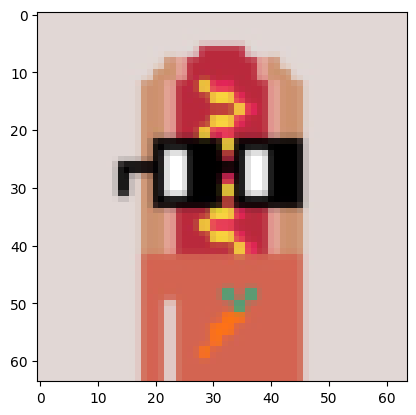

In [7]:
image_id = 0
image = dataset[image_id]

plt.imshow((image.permute(1, 2, 0) + 1) * 0.5)

In [20]:
mu, _ = vae.encode(image.unsqueeze(0))
latent = mu.view(1, -1)
features = sae.encode(latent).squeeze(0)
feature_indices = torch.where(features != 0)
activations = features[feature_indices]

features_list = []

for i in range(activations.shape[0]):
    features_list.append({
        "feature_id": int(feature_indices[0][i].item()),
        "activation": activations[i].item()
    })

features_list = sorted(features_list, key=lambda x: x["activation"], reverse=True)
features_list

[{'feature_id': 197, 'activation': 2.955507278442383},
 {'feature_id': 685, 'activation': 0.12281584739685059},
 {'feature_id': 481, 'activation': 0.08602398633956909},
 {'feature_id': 896, 'activation': 0.08587047457695007},
 {'feature_id': 1000, 'activation': 0.0675773024559021},
 {'feature_id': 687, 'activation': 0.03907740116119385},
 {'feature_id': 112, 'activation': 0.03437304496765137}]